### This notebook extracts samples of parameters from within a specified DSGRN parameter node corresponding to a specified network topology, constructs the associated ODE Hill function model and generates synthetic time series through numerical integration of that system of ODEs. 

In [1]:
import re
import os
import json 
import DSGRN
import sqlite3
import datetime
import numpy as np
import pandas as pd
from scipy.integrate import ode
import matplotlib.pyplot as plt
import pattern_match_single_param as pmsp

There are 2016 nodes in the parameter graph.


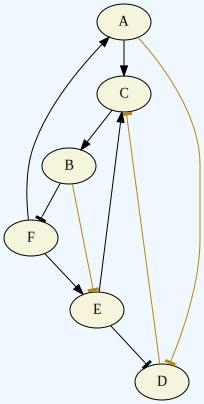

In [2]:
# DSGRN network specification file
network_file = 'syn_net_6D_20191104_a.txt'

# Create the DSGRN network object
network = DSGRN.Network(network_file)

# Compute the DSGRN parameter graph
param_graph = DSGRN.ParameterGraph(network)

print("There are " + str(param_graph.size()) + " nodes in the parameter graph.")

# Create a DSGRN parameter node sampler object
sampler = DSGRN.ParameterSampler(network)

# Plot the network
DSGRN.DrawGraph(network)

112 samples tested, match found = True.


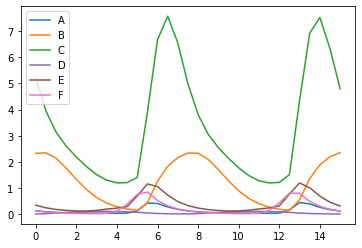

In [3]:
%run -i 'hillmodel.py'

# Specify a parameter node in the parameter graph from which to sample
param_ind = 1945

# Specify the ODE model Hill exponent, initial conditions, coarse time series 
# sampling range and rate and fold-change threshold
hill_exp = 5
init_cond = np.random.rand(6)
trace_total_time = 15
trace_num_samp = 30
fold_thresh = 4 

# ---------------------------------------------
param_node = param_graph.parameter(param_ind)

# Sample from the specified parameter node until a parameter choice is found which exhibits fold change above the threshold
# and has min-max ordering in agreement with DSGRN predictions
count = 0

while count < 1000:
    
    count = count + 1

    # Sample from the specified parameter node
    param_samp_dict = json.loads(sampler.sample(param_node))['Parameter']  # dictionary of parameter choices

    # Create Hill function ODE models
    hill_model = hillmodel(network_file, param_samp_dict, hill_exp, old_format=False)

    # Integrate parameterized ODEs for long time to remove transients, using a fine time step
    # and verify the min-max ordering matches the DSGRN prediction at 0 noise level
    fine_time, fine_traces, nodes = hill_model.simulateHillModel(init_cond, 0, 20, .01)

    # Integrate parameterized ODEs for shorter time with coarser sampling
    samp_time, samp_traces, nodes = hill_model.simulateHillModel(fine_traces[-1],
                                                                 0,
                                                                 trace_total_time,
                                                                 trace_total_time / trace_num_samp)

    # Check that the fold change of all traces exceeds the threshold
    fold_change = all(
        (np.array(samp_traces).max(axis=0) - np.array(samp_traces).min(axis=0)) / np.array(samp_traces).min(
            axis=0) > fold_thresh)

    if fold_change:
        # Check that the coarse time series at this Hill function parameter matches the dynamic predictions of DSGRN
        domain_match, full_cycle, poset = pmsp.main(param_ind, param_graph, network, samp_time, samp_traces, epsilons=[0.0])
        if domain_match and full_cycle:
            break


        
print("{} samples tested, match found = {}.".format(count,fold_change and domain_match and full_cycle))

if fold_change and domain_match and full_cycle:
    # Save the parameter values and coarsely-sampled time series traces of the ODE simulatation to disk
    syn_net_dict = {'Network': network.specification(),
                    'Parameter Index': param_ind,
                    'Parameter': param_samp_dict,
                    'Hill Exponent': hill_exp,
                    'Time': samp_time,
                    'Traces': [list(trace) for trace in samp_traces],
                    'Nodes': nodes}

    filename = os.path.splitext(os.path.split(os.path.abspath(network_file))[1])[0]
    outdir = os.path.split(os.path.abspath(network_file))[0] + '/'
    with open(outdir + filename + '_hillmodel_p{}.json'.format(param_ind), 'w') as f:
        json.dump(syn_net_dict, f)

    trace_df = pd.DataFrame()   
    trace_df['time'] = samp_time
    for i in range(len(nodes)):
        trace_df[nodes[i]] = np.array(samp_traces)[:,i]

    # Save the time series traces to a pipeline readable .tsv file
    with open(outdir + filename + '_data_p{}.tsv'.format(param_ind), 'w') as f:
        f.write("# Time series from %s, output to pipeline readable format\n" %(filename + '_hillmodel_p{}.json'.format(param_ind)))
        f.write("# Generated on %s\n" %datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
        trace_df = trace_df.set_index('time').transpose().rename_axis('time').to_csv(f, sep='\t', index=True)


# plot the traces for visual inspection and sanity check
hill_model.plotResults(samp_time, samp_traces)